# Latent Space Approaches to Social Network Analysis

## Introduction

In the study of historical social networks, the relationships between influential families provide valuable insights into power dynamics, alliances, and social structures. One such case is the analysis conducted by Padgett and Ansell (1993), which examines marriage and business ties among 16 historically prominent Florentine families during the 15th century. Their work is based on historical accounts, particularly the research of Kent (1978), which documents the socio-political landscape of Renaissance Florence.

This notebook focuses specifically on the marriage relations between these families. In this dataset, a tie exists between two families if at least one marriage occurred between them. The relationship is undirected, as the records do not specify the respective families of the husband and wife. Notably, one of the 16 families had no marriage ties to others and was consequently excluded from the analysis. Including this family would result in an infinite distance in a maximum likelihood estimation and a large but finite distance in a Bayesian framework. By modeling these marriage relations using network analysis techniques, we can explore the structural properties of the Florentine elite and their strategic matrimonial alliances. This analysis provides a deeper understanding of the role of marriage in shaping political and economic power during the Renaissance. This work is inspired and replicated according the article of Hoff 2002 (consult [1]).

We are going to use the following libraries:

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

np.random.seed(42)

## Florentine Families Network

The graph of the Florentine families is presented in the following plot.

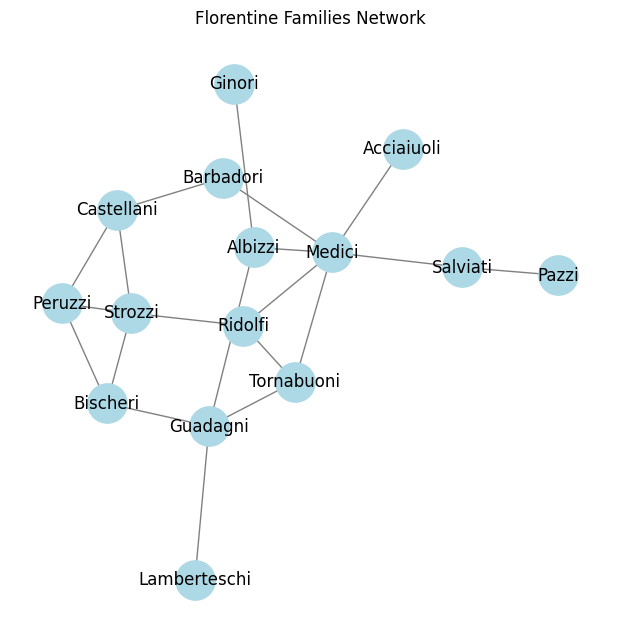

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()


It is important to reindex with integer number the previous network in order to deal with nodes and edges easily.

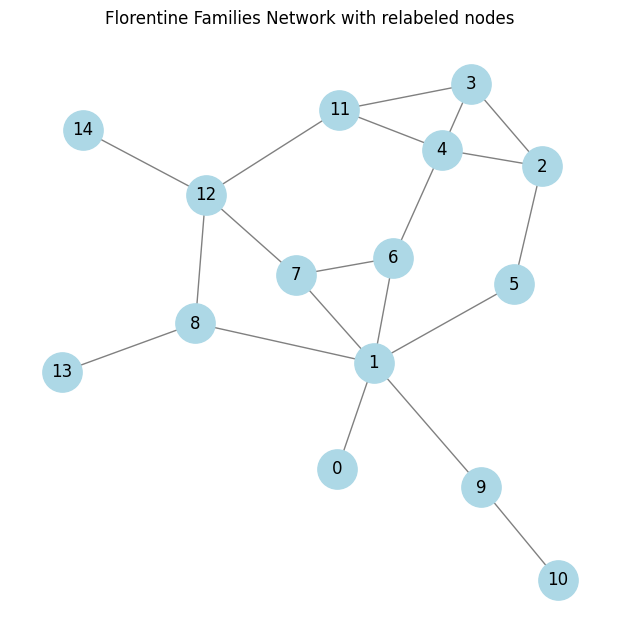

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [3]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

The sociomatrix $Y$ or adjacency matrix is calculated in the following code.

In [4]:
nx.to_numpy_array(G, dtype=int)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

<Axes: >

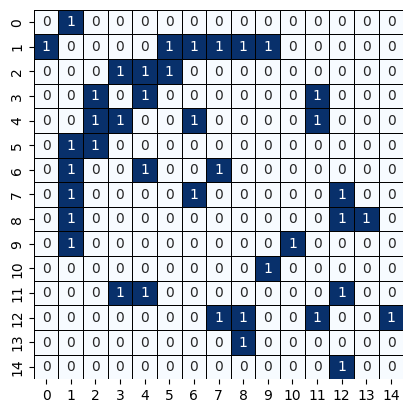

In [5]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')

## Latent Space

To start the latent space model, the number of nodes $n$ in the graph is calculated and the latent variables are randomly initialized with sampling from a normal standard distribution a matrix of size $n\times 2$ since we are representing our network in a $2$-dimensional space.

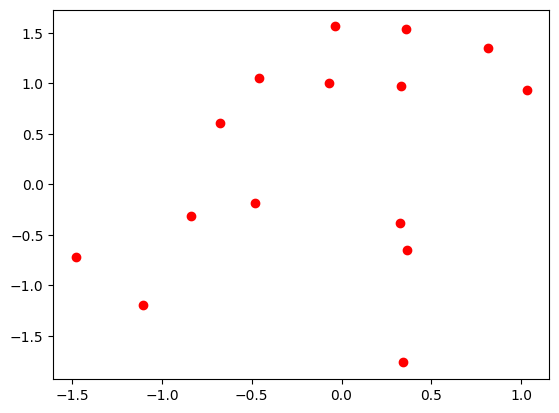

In [6]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

## Likelihood

In order to calculate the probability to have a tie between two nodes given the latent variables and its properties, the following model is proposed:


$$\eta_{ij} := logit(\mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a)) = a (1-d_{ij}),$$

equivalently,

$$\mu_{ij} := \mathbb{P}(y_{ij}=1\ |\ z_i,z_j,a) = expit(a (1-d_{ij})) = \frac{1}{1+\exp{(-a(1-d_{ij}))}},$$

where $d_{ij}$ measures the distance between the two latent variables in the next way,

$$d_{ij} = \frac{1}{2}\|z_i-z_j\|^2.$$

Since $y_{ij}\in\{0,1\}$ and we suppose that the conection bewteen edges are independente, then the likelihood is given by the expression

$$L(\eta) = \mathbb{P}(Y\ |\ \eta) = \prod_{i\not=j} \mu_{ij}^{y_{ij}}(1-\mu_{ij})^{1-y_{ij}},$$


and the log-likelihood

$$\ell(\eta) = \log(\mathbb{P}(Y\ |\ \eta)) = \sum_{i\not=j} \eta_{ij}y_{ij} - \log(1+e^{\eta_{ij}}),$$

with its respective derivatives,


$$\frac{\partial}{\partial z_{k}} \ell(\eta) = \sum_{i\not=k} a (z_k-z_i)\left(expit(\eta_{ki})- y_{ki}\right),$$

$$\frac{\partial}{\partial a} \ell(\eta) =  \sum_{i\not=j} (1-d_{ij})\left(expit(\eta_{ki})- y_{ki}\right).$$

In [124]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j in G.neighbors(i):
                eta = a * ( 1 - 0.05 * np.linalg.norm(Z[i] - Z[j])**2)
                total += eta * 1  + np.log(expit(-eta))
            elif j != i:
                eta = a * ( 1 - 0.05 * np.linalg.norm(Z[i] - Z[j])**2)
                total += np.log(expit(-eta))
    return total

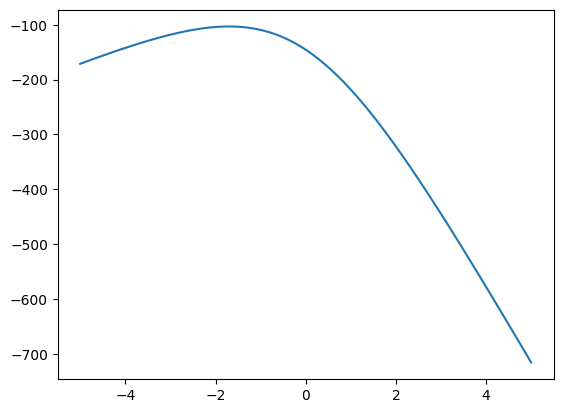

In [125]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t) for t in np.linspace(-5,5,100)])
plt.show()

In [128]:
def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = 0.05 * np.linalg.norm(Z[i] - Z[j])**2
                eta = a* ( 1 - dist )
                grad_Z[i,:] +=  a * (Z[i] - Z[j]) * (expit(eta) - y)
                grad_a += (-1) * (1-dist) * (expit(eta) - y) 
    return grad_Z, grad_a

-151.19426327815108
-135.8558660226764


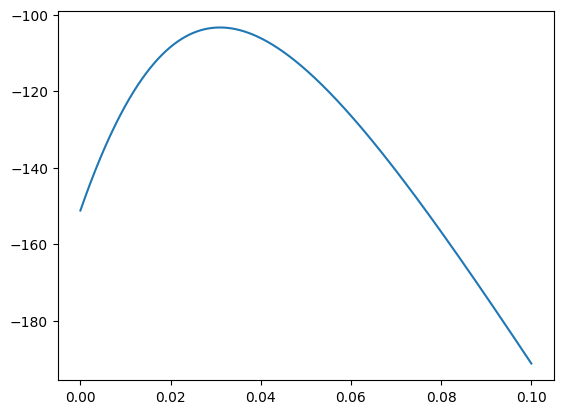

In [129]:
grad_Z,  grad_a = grad_loglikelihood(Z,0.1)
lr = 0.005
print(loglikelihood(Z,0.1))
print(loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

### Searching MLE

For searching the maximum likelihood estimation, we search the maximum of the loglikelihood function through gradient descent with line search.

In [130]:
def SearchingMLE(Z_init, a_init, tol=1e-1, max_iter=1000, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(Z0 + alpha * grad_Z,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = Z0 + alpha * grad_Z  
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

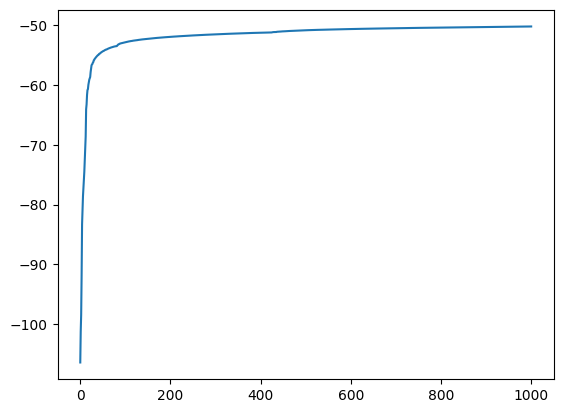

In [131]:
Z0, a0, historyZ, historya  =  SearchingMLE(np.random.randn(n, 2),np.random.randn())
Z0 = Z0 - np.mean(Z0, axis=0)
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

In [155]:
print(loglikelihood(Z0,a0))
print(loglikelihood(np.random.randn(n, 2),np.random.randn()))

-50.225381113723714
-120.15205930820198


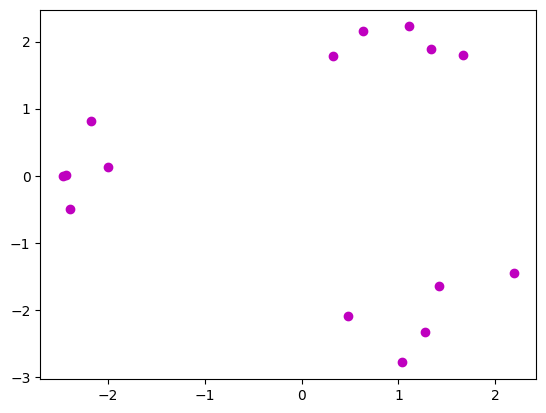

In [133]:
plt.plot(Z0[:,0],Z0[:,1], 'mo')
plt.show()

### Sociomatrix

In [134]:
Z0

array([[ 0.32663831,  1.78555342],
       [ 1.03334821, -2.78252646],
       [-2.39488482, -0.50237081],
       [ 1.662334  ,  1.80265554],
       [ 1.27782767, -2.33388447],
       [ 1.33547221,  1.88373823],
       [ 1.11066651,  2.22471273],
       [-2.43008553,  0.00764213],
       [-2.17368558,  0.81190672],
       [ 0.63128684,  2.1531725 ],
       [ 0.47935803, -2.08509305],
       [-2.46666536, -0.00563778],
       [ 2.19014426, -1.45292395],
       [ 1.41569241, -1.64235586],
       [-1.99744717,  0.1354111 ]])

In [135]:
a0

np.float64(-10.8099413683409)

In [136]:
Y = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y[i,j] = expit(a0 * (1 - 0.05 * np.linalg.norm(Z0[i] - Z0[j])**2))

<Axes: >

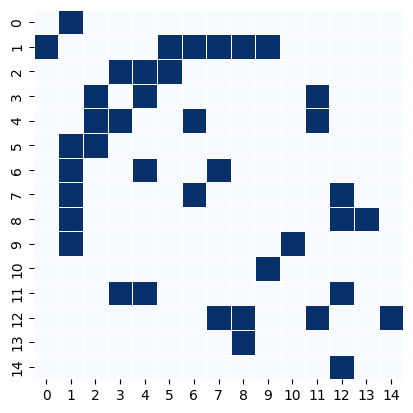

In [137]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')

<Axes: >

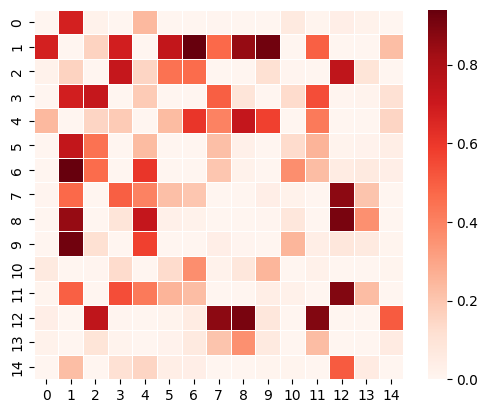

In [138]:
sns.heatmap(Y, annot=False, cmap="Reds", cbar=True, square=True, linewidths=0.5, linecolor='white')

## A priori distribution

In [139]:
def logpriori(Z,a,var=10):
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + 0.5 * np.sum(Z**2)/var + 0.5 * a**2 / var)

In [140]:
def grad_logpriori(Z,a,var=10):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (-1) * Z[i,:] / var
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

-34.32724065386913
-33.12369727522713


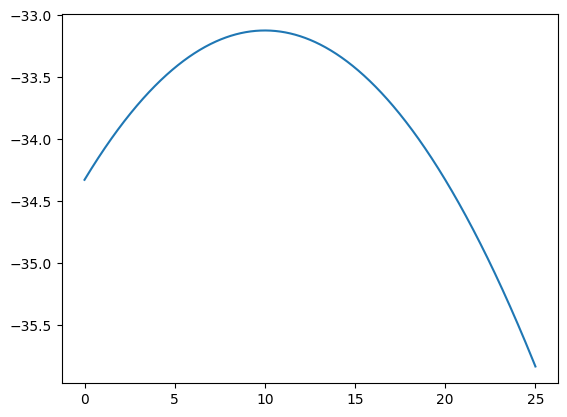

In [141]:
grad_Z,  grad_a = grad_logpriori(Z,0.1)
lr = 10
print(logpriori(Z,0.1))
print(logpriori(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,25.0,1000),[logpriori(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,25.0,1000)])
plt.show()

## Potential energy

In [142]:
def U(Z,a,var=100):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=100):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

202.8589956351948
187.52086202093872


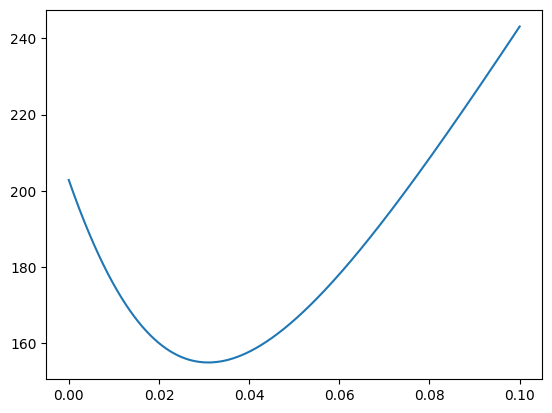

In [143]:
grad_Z,  grad_a = grad_U(Z,0.1)
lr = 0.005
print(U(Z,0.1))
print(U(Z - lr*grad_Z,0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[U(Z -lr*grad_Z,0.1-lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [157]:
def compute_Z_star(Z, Z0):
    """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
    A = Z @ Z0.T @ Z0 @ Z.T  # Compute A = Z Z0^T Z0 Z^T
    
    # Compute A^(-1/2) using SVD
    U, S, _ = np.linalg.svd(A)
    S_inv_sqrt = np.diag(1.0 / np.sqrt(S))
    A_inv_sqrt = U @ S_inv_sqrt @ U.T
    Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
    # Compute Z*
    return Z_star - np.mean(Z_star, axis=0)

In [161]:
np.mean(compute_Z_star(np.random.randn(n,2), Z0),axis=0)

array([2.96059473e-17, 8.04911693e-17])

In [163]:
def hmc(Z_init, a_init, num_samples, epsilon=0.05, L=3, std_dev=1.0):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Z = Z_init.copy()
    a = a_init.copy()
    
    for _ in range(num_samples):

        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        ### HMC algorithm for Z
        p = np.random.normal(0, std_dev, size=Z.shape)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_Z / 2        
        for _ in range(L):
            Z += epsilon * p
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            p -= epsilon * grad_Z
        p -= epsilon * grad_Z / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = np.sum(current_p ** 2) / 2
        current_H = current_U + current_K
        proposed_U = U(Z,samples_a[-1])
        proposed_K = np.sum(p ** 2) / 2
        proposed_H = proposed_U + proposed_K
        # Metropolis-Hastings acceptance rate
        ar = min(np.exp(current_H - proposed_H), 1)
        if np.random.rand() > ar:
            Z_C = compute_Z_star(Z, Z_init)
            samples_Z.append(Z_C.copy())
        else:
            samples_Z.append(samples_Z[-1])

        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = np.sum(current_p ** 2) / 2
        current_H = current_U + current_K
        proposed_U = U(samples_Z[-1],a)
        proposed_K = np.sum(p ** 2) / 2
        proposed_H = proposed_U + proposed_K
        # Metropolis-Hastings acceptance rate
        ar = min(np.exp(current_H - proposed_H), 1)
        if np.random.rand() > ar:
            samples_a.append(a.copy())
        else:
            samples_a.append(samples_a[-1])

    
    return samples_Z, samples_a

## Results and visualization

In [164]:
samples_Z, samples_a = hmc(Z0,a0,5000)

C:\Users\carlo\AppData\Local\Temp\ipykernel_11140\4167707572.py:59: RuntimeWarning: overflow encountered in exp
  ar = min(np.exp(current_H - proposed_H), 1)


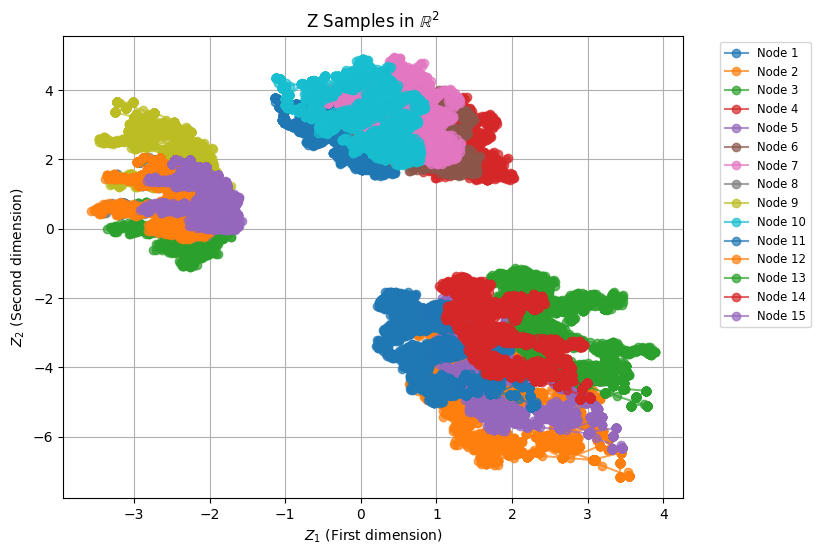

In [165]:
def plot_Z_samples(samples_Z):
    """
    Plots the trajectory of each row of Z in R^2, 
    differentiating them by color.
    
    Args:
        samples_Z (list of np.array): List of Z matrices of shape (15, 2).
    """
    samples_Z = np.array(samples_Z)  # Convert to numpy array
    num_points = samples_Z.shape[1]  # Number of rows in Z

    plt.figure(figsize=(8, 6))

    # Plot the trajectory of each row in Z
    for i in range(num_points):
        trace = samples_Z[:, i, :]  # Extract trajectory for point i
        plt.plot(trace[:, 0], trace[:, 1], marker="o", linestyle="-", alpha=0.7, label=f"Node {i+1}")

    plt.xlabel("$Z_1$ (First dimension)")
    plt.ylabel("$Z_2$ (Second dimension)")
    plt.title("Z Samples in $\\mathbb{R}^2$")
    plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.show()

# Llamada a la función con tus datos
plot_Z_samples(samples_Z)


In [149]:
samples_a

[np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 np.float64(-10.8099413683409),
 array([-10.77011522]),
 array([-10.77011522]),
 array([-10.77011522]),


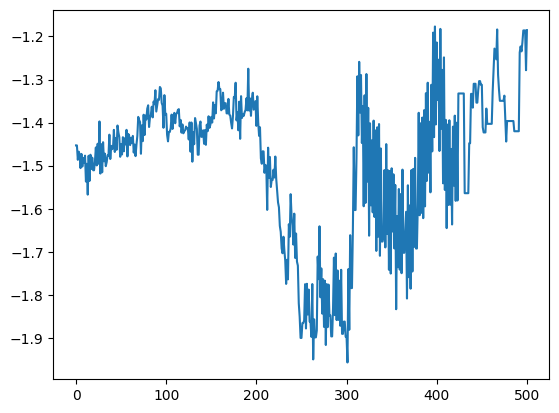

In [150]:
plt.plot(np.array(samples_Z)[:,12,:][:,1]) 

In [151]:
[-loglikelihood(samples_Z[i],samples_a[i]) for i in range(1,500)]

[np.float64(50.225381113723714),
 np.float64(51.037194660498706),
 np.float64(50.32805829360021),
 np.float64(50.8883492326461),
 np.float64(52.36273032746257),
 np.float64(51.05492882800635),
 np.float64(52.68874169779998),
 np.float64(50.951760302721205),
 np.float64(51.16277214023901),
 np.float64(52.05111442393015),
 np.float64(52.26453976101267),
 np.float64(51.57246398208066),
 np.float64(53.80965705139301),
 np.float64(51.25320662340967),
 np.float64(52.51345139759832),
 np.float64(51.53252156226256),
 np.float64(51.34794832580571),
 np.float64(52.34308193884876),
 np.float64(51.59379430229251),
 np.float64(51.59379430229251),
 np.float64(50.920147476256936),
 np.float64(51.04711913481417),
 np.float64(50.98926434733357),
 np.float64(50.52271712540268),
 np.float64(50.7072935121214),
 np.float64(51.57960528099609),
 np.float64(51.44997495838937),
 np.float64(50.65964492614272),
 array([51.35439812]),
 array([50.92756408]),
 array([51.05637584]),
 array([50.66737522]),
 array([51

## References

[1] Hoff, P. D., Raftery, A. E., & Handcock, M. S. (2002). Latent space approaches to social network analysis. Journal of the American Statistical Association, 97(460), 1090-1098. https://doi.org/10.1198/016214502388618906